## Importing/defining appropriate libraries, functions, dictionaries, and data

First, we need to import the appropriate python packages, custom functions, and helpful dictionaries.

In [1]:
#standard 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

#model to use
from sklearn.ensemble import RandomForestClassifier

#model performance
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold, RandomizedSearchCV, train_test_split
from scipy.stats import randint as sp_randint
from time import time

#for easy visualization of model performance
import scikitplot as skplt

#custom function for trim mean and std deviation
def trim_mean_std(data, frac=0.05):    
    mean = stats.trim_mean(data, frac)
    std = stats.tstd(data, limits=(frac * np.max(data), (1 - frac) * np.max(data)))
    return mean, std

#custom ECDF functions
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

def logistic_cdf(data, size=10000, frac=0.025):
    mean = stats.trim_mean(data, frac)
    std = stats.tstd(data, limits = (frac * np.max(data), (1 - frac) * np.max(data)))
    samples = np.random.logistic(mean, std /2, size = size)
    x,y = ecdf(samples)
    return x, y

def normal_cdf(data, size=10000, frac=0.025):
    mean = stats.trim_mean(data, frac)
    std = stats.tstd(data, limits = (frac * np.max(data), (1 - frac) * np.max(data)))
    samples = np.random.normal(mean, std, size = size)
    x,y = ecdf(samples)
    return x, y

#Dictionary to convert amino acid abreviations
aa_dict = {'ALA': 'A', 'CYS':'C', 'ASP': 'D', 'GLU':'E',
          'PHE': 'F', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
          'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N',
          'GLN': 'Q', 'ARG': 'R', 'SER': 'S', 'THR': 'T',
          'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'}

#Dictionary to bucket amino acids
condensed_dict = {'L': 'LAIVMH', 'A': 'LAIVMH', 'I': 'LAIVMH', 'V': 'LAIVMH', 'M': 'LAIVMH', 'H': 'LAIVMH',
                  'D': 'DEQ', 'E': 'DEQ', 'Q': 'DEQ', 
                  'S': 'STGRFN', 'T': 'STGRFN', 'G': 'STGRFN', 'R': 'STGRFN', 'F': 'STGRFN', 'N': 'STGRFN',
                  'K': 'K'}

LB doping experiments were conducted on two different soluble proteins: IGPS and PTP1B. Here the raw NMR data with different % LB dopant are uploaded.  

In [41]:
#importing data
IGPS = pd.read_csv('data/IGPS_8hr_0513.csv').dropna(axis=0)
PTP1B = pd.read_csv('data/PTP1B_8hr_0513.csv').dropna(axis=0)

#rearranging columns and setting AA colum to single letter abbreviation
PTP1B = PTP1B[['0%', '1%', '5%', '10%', 'AA']]
PTP1B[['AA']] = PTP1B[['AA']].apply(lambda x: x.str[0])
PTP1B = PTP1B[PTP1B['AA'] != 'X']

IGPS = IGPS[['0%', '1%', '5%', '10%', 'AA']]
IGPS[['AA']] = IGPS['AA'].map(aa_dict)

#converting labels to categorical variables
IGPS.AA = IGPS.AA.astype('category')
PTP1B.AA = PTP1B.AA.astype('category')

#combining data
both_proteins = pd.concat([IGPS, PTP1B] , axis=0, ignore_index=True)

#label protein in overall array
proteins = ['IGPS'] * IGPS.shape[0] + ['PTP1B'] * (both_proteins.shape[0] - IGPS.shape[0])
both_proteins['protein'] = pd.Series(proteins)

#Check imported data
both_proteins.head()

,0%,1%,5%,10%,AA,protein
0,70817.0,48836.26190,35416.90963,13722.06797,A,IGPS
1,56457.0,41255.86774,34030.53055,14549.18591,A,IGPS
2,84293.0,70637.32580,51737.79568,24447.40255,A,IGPS
3,37792.0,27637.72522,20032.70190,12014.13218,A,IGPS
4,87872.0,68161.90034,47255.06422,34808.69365,C,IGPS


## Feature engineering

To describe the relative relationships between the LB dopant concentrations, the new features below were generated: 
- 1/0, 5/0, 10/0
- 5/1, 10/1
- 10/5


In [3]:
#feature engineering
div_by_zero = both_proteins[['1%', '5%', '10%']].values / both_proteins[['0%']].values #we add .values here to convert to numpy array
div_by_one = both_proteins[['5%', '10%']].values / both_proteins[['1%']].values
div_by_five = both_proteins[['10%']].values / both_proteins[['5%']].values

ratio_cols = ['1/0', '5/0', '10/0', '5/1', '10/1', '10/5']

ratios = np.concatenate((div_by_zero, div_by_one, div_by_five), axis=1)
ratios_df = pd.DataFrame(ratios, columns=ratio_cols)
ratios_df['protein'] = both_proteins['protein']

ratios_df.head()

,1/0,5/0,10/0,5/1,10/1,10/5,protein
0,0.689612,0.500119,0.193768,0.725217,0.280981,0.387444,IGPS
1,0.730748,0.602769,0.257704,0.824865,0.352657,0.427533,IGPS
2,0.837998,0.613785,0.290029,0.732443,0.346098,0.472525,IGPS
3,0.731312,0.530078,0.317901,0.724832,0.434700,0.599726,IGPS
4,0.775695,0.537772,0.396130,0.693277,0.510677,0.736613,IGPS


## Visualizing distribution of data

To better understand how to preprocess this data, We visualized the distribution of the data to determine if it is appropriate to scale the datasets. 

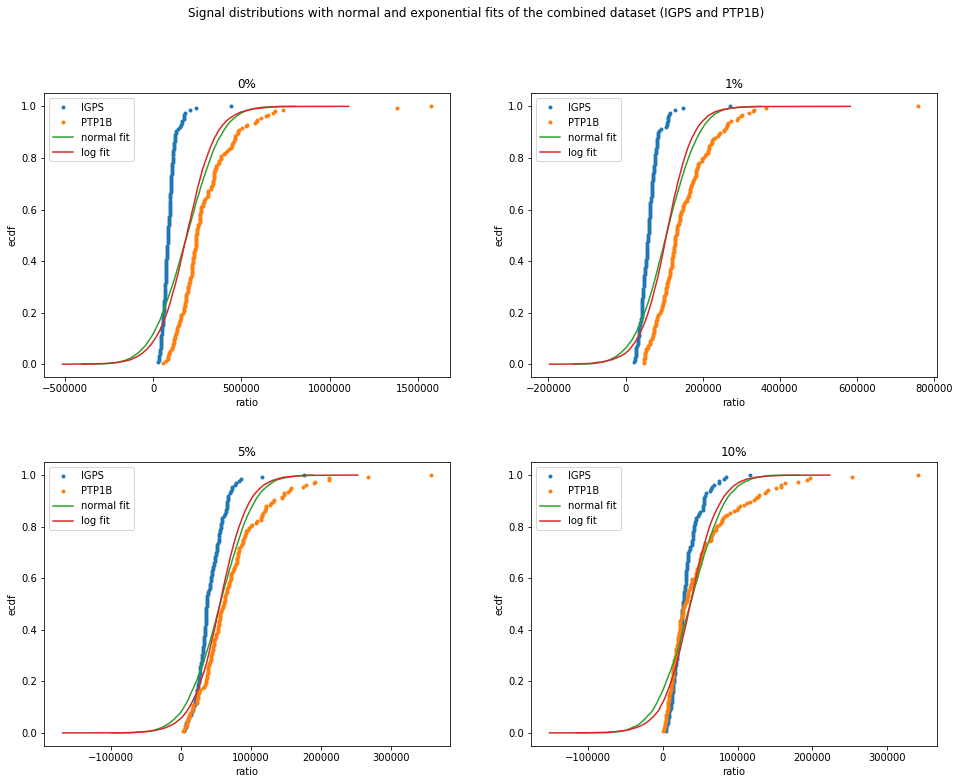

In [4]:
#data distribution of ratios
fig = plt.figure(figsize=(16,12))
fig.suptitle('Signal distributions with normal and exponential fits of the combined dataset (IGPS and PTP1B)')
plt.subplots_adjust(hspace=0.3)
num_cols = ['0%', '1%', '5%', '10%']
for i, col in enumerate(num_cols):
    ax = fig.add_subplot(2, 2, i+1)
    ax.plot(ecdf(both_proteins[col][both_proteins['protein'] == 'IGPS'])[0], 
            ecdf(both_proteins[col][both_proteins['protein'] == 'IGPS'])[1], 
            marker='.', linestyle='none', label='IGPS')
    
    ax.plot(ecdf(both_proteins[col][both_proteins['protein'] == 'PTP1B'])[0], 
            ecdf(both_proteins[col][both_proteins['protein'] == 'PTP1B'])[1], 
            marker='.', linestyle='none', label='PTP1B') 
    
    ax.plot(normal_cdf(both_proteins[col])[0], normal_cdf(both_proteins[col])[1], label='normal fit') 
    ax.plot(logistic_cdf(both_proteins[col])[0], logistic_cdf(both_proteins[col])[1], label='log fit') 
    ax.set_title(col)
    ax.set_xlabel('ratio')
    ax.set_ylabel('ecdf')
    plt.legend()

The normal and logistic fit of the combined PTP1B and IGPS data sets are not representative of the data set. Lets try scaling each data set separately. 

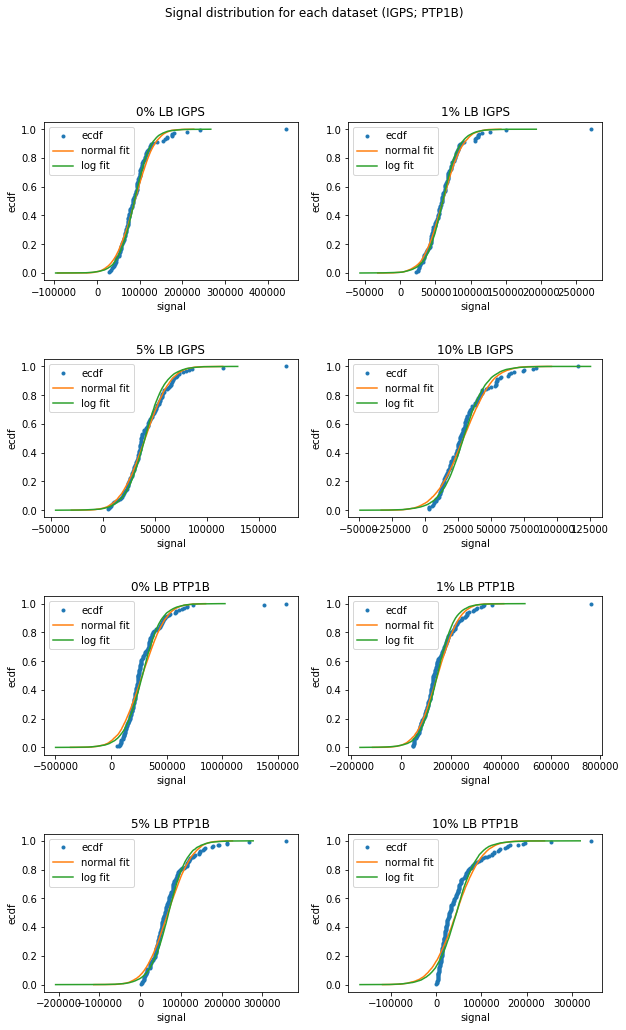

In [5]:
fig = plt.figure(figsize=(10,16))
fig.suptitle('Signal distribution for each dataset (IGPS; PTP1B)')

#data distribution of IGPS
for i, col in enumerate(num_cols):
    ax = fig.add_subplot(4, 2, i+1)
    ax.plot(ecdf(IGPS[col])[0], ecdf(IGPS[col])[1], marker='.', linestyle='none', label='ecdf') 
    ax.plot(normal_cdf(IGPS[col])[0], normal_cdf(IGPS[col])[1], label='normal fit') 
    ax.plot(logistic_cdf(IGPS[col])[0], logistic_cdf(IGPS[col])[1], label='log fit') 
    ax.set_title(col + ' LB' + ' IGPS')
    ax.set_xlabel('signal')
    ax.set_ylabel('ecdf')
    plt.legend()

#data distribution of PTP1B
for i, col in enumerate(num_cols):
    ax = fig.add_subplot(4, 2, i+5)
    ax.plot(ecdf(PTP1B[col])[0], ecdf(PTP1B[col])[1], marker='.', linestyle='none', label='ecdf') 
    ax.plot(normal_cdf(PTP1B[col])[0], normal_cdf(PTP1B[col])[1], label='normal fit') 
    ax.plot(logistic_cdf(PTP1B[col])[0], logistic_cdf(PTP1B[col])[1], label='log fit') 
    ax.set_title(col + ' LB' + ' PTP1B')
    ax.set_xlabel('signal')
    ax.set_ylabel('ecdf')
    plt.legend()
    
plt.subplots_adjust(hspace=0.5)

The datasets are better described by the normal or log fits of each protein separately.

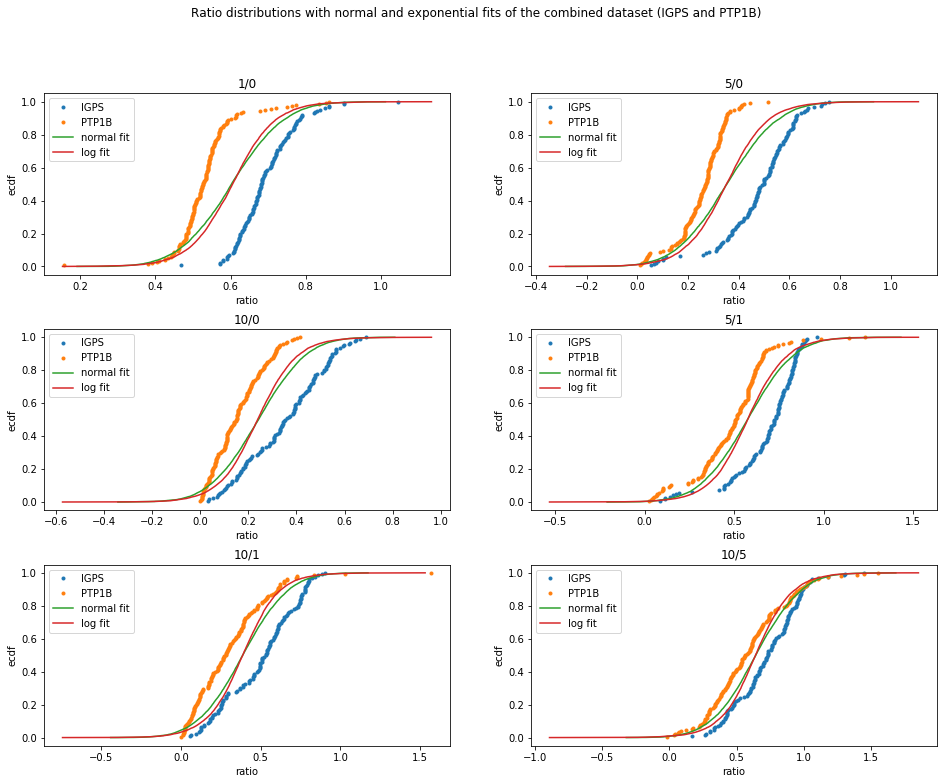

In [6]:
#data distribution of ratios
fig = plt.figure(figsize=(16,12))
fig.suptitle('Ratio distributions with normal and exponential fits of the combined dataset (IGPS and PTP1B)')
plt.subplots_adjust(hspace=0.3)
for i, col in enumerate(ratio_cols):
    ax = fig.add_subplot(3, 2, i+1)
    ax.plot(ecdf(ratios_df[col][ratios_df['protein'] == 'IGPS'])[0], 
            ecdf(ratios_df[col][ratios_df['protein'] == 'IGPS'])[1], 
            marker='.', linestyle='none', label='IGPS')
    
    ax.plot(ecdf(ratios_df[col][ratios_df['protein'] == 'PTP1B'])[0], 
            ecdf(ratios_df[col][ratios_df['protein'] == 'PTP1B'])[1], 
            marker='.', linestyle='none', label='PTP1B') 
    
    ax.plot(normal_cdf(ratios_df[col])[0], normal_cdf(ratios_df[col])[1], label='normal fit') 
    ax.plot(logistic_cdf(ratios_df[col])[0], logistic_cdf(ratios_df[col])[1], label='log fit') 
    ax.set_title(col)
    ax.set_xlabel('ratio')
    ax.set_ylabel('ecdf')
    plt.legend()

Again, the normal fits of the combined datasets dooesnot describe the dataset well.

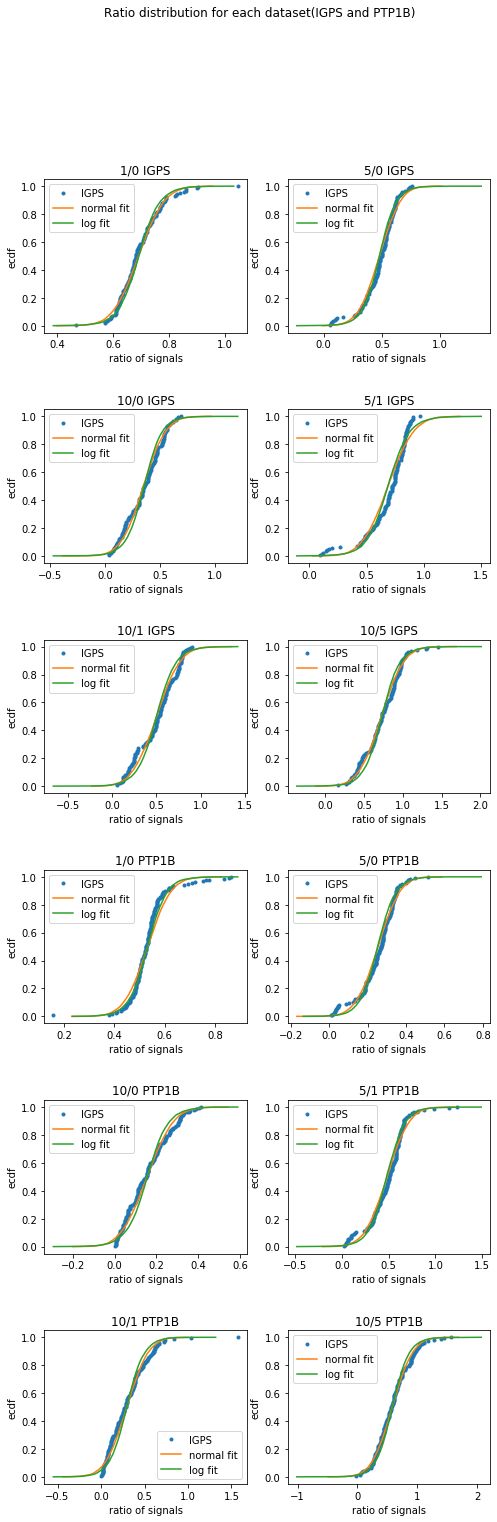

In [7]:
fig = plt.figure(figsize=(8,24))
fig.suptitle('Ratio distribution for each dataset(IGPS and PTP1B)')

#data distribution of IGPS
for i, col in enumerate(ratio_cols):
    ax = fig.add_subplot(6, 2, i+1)
    ax.plot(ecdf(ratios_df[col][ratios_df['protein'] == 'IGPS'])[0], 
            ecdf(ratios_df[col][ratios_df['protein'] == 'IGPS'])[1], 
            marker='.', linestyle='none', label='IGPS')
    
    ax.plot(normal_cdf(ratios_df[col][ratios_df['protein'] == 'IGPS'])[0], 
            normal_cdf(ratios_df[col][ratios_df['protein'] == 'IGPS'])[1], 
            label='normal fit') 
    
    ax.plot(logistic_cdf(ratios_df[col][ratios_df['protein'] == 'IGPS'])[0], 
            logistic_cdf(ratios_df[col][ratios_df['protein'] == 'IGPS'])[1], 
            label='log fit') 
    
    ax.set_title(col + ' IGPS')
    ax.set_xlabel('ratio of signals')
    ax.set_ylabel('ecdf')
    plt.legend()

#data distribution of PTP1B
for i, col in enumerate(ratio_cols):
    ax = fig.add_subplot(6, 2, i+7)
    ax.plot(ecdf(ratios_df[col][ratios_df['protein'] == 'PTP1B'])[0], 
            ecdf(ratios_df[col][ratios_df['protein'] == 'PTP1B'])[1], 
            marker='.', linestyle='none', label='IGPS')
    
    ax.plot(normal_cdf(ratios_df[col][ratios_df['protein'] == 'PTP1B'])[0], 
            normal_cdf(ratios_df[col][ratios_df['protein'] == 'PTP1B'])[1], 
            label='normal fit') 
    
    ax.plot(logistic_cdf(ratios_df[col][ratios_df['protein'] == 'PTP1B'])[0], 
            logistic_cdf(ratios_df[col][ratios_df['protein'] == 'PTP1B'])[1], 
            label='log fit') 
    
    ax.set_title(col + ' PTP1B')
    ax.set_xlabel('ratio of signals')
    ax.set_ylabel('ecdf')
    plt.legend()
    
plt.subplots_adjust(hspace=0.5)

Based off of the analysis above, Zscore normalization was performed for each dataset.

Also, in order to determine which labels should be included in the data, let's see how many data points we have for each label in each protein.

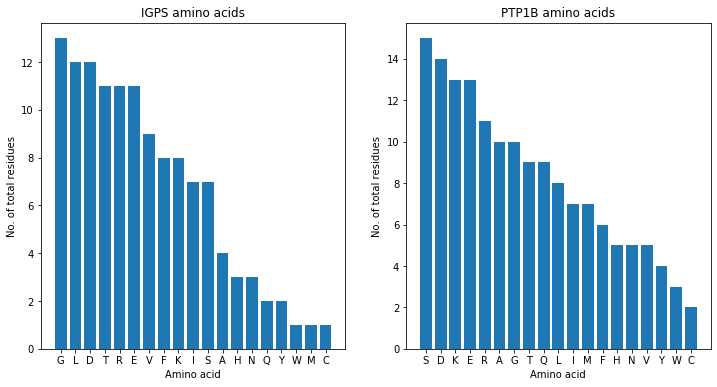

In [8]:
aa_freq_IGPS = dict(IGPS.AA.value_counts())
aa_freq_PTP1B = dict(PTP1B.AA.value_counts())

plt.figure(figsize=(12,6))

#IGPS
plt.subplot(121)
plt.bar(range(len(aa_freq_IGPS)), aa_freq_IGPS.values(), align='center')
plt.xticks(range(len(aa_freq_IGPS)), list(aa_freq_IGPS.keys()))
plt.ylabel('No. of total residues')
plt.xlabel('Amino acid')
plt.title('IGPS amino acids')

#PTP1B
plt.subplot(122)
plt.bar(range(len(aa_freq_PTP1B)), aa_freq_PTP1B.values(), align='center')
plt.xticks(range(len(aa_freq_PTP1B)), list(aa_freq_PTP1B.keys()))
plt.ylabel('No. of total residues')
plt.xlabel('Amino acid')
plt.title('PTP1B amino acids')

plt.show()

We decided to exclude Y, W, and C from the analysis because there are less than 5 data points for these residues. 

We can write a function to flexibly include and exclude amino acids:

In [9]:
def create_filter(AA_excluded, y, reverse=False):
    all_labels = ['L','A', 'I', 'V', 'D', 'E', 'Q', 'S', 'T', 'F', 'G', 'H', 'R', 'K', 'C', 'N', 'M', 'W', 'Y' ]
    labels = [x for x in all_labels if x not in AA_excluded]
    my_filter = [True if aa not in AA_excluded else False for aa in y]
    if reverse == True:
        reverse_filter = [True if aa in AA_excluded else False for aa in y]
        return my_filter, labels, reverse_filter
    else:
        return my_filter, labels

## Preprocessing and splitting the data

Functions were made to streamline the preprocessing:
1. z-score
2. log transform data set, then trimmed z-score (for NMR signal)

Trimmed means and standard deviations were used for the z-score calculations. 

In [10]:
#normal z score function
def z_score(data):
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    zeroed_data = np.subtract(data, means)
    scaled_data = np.divide(zeroed_data, stds)
    return scaled_data 

#trim z score function
def trim_log_z_score(data, frac=0.05):
    '''
    Args:
    data (NUMPY ARRAY!!): numpy array of data to be log transformed and scaled, not robust to negative numbers
    frac (float): how much to trim mean and standard deviation
    Returns:
    scaled_data (numpy array): log transformed and scaled data
    '''
    log_data = np.log(np.clip(data, 0.1, None))
    trim_means_and_std = np.apply_along_axis(func1d=trim_mean_std, axis=0, arr=log_data, frac=frac)
    means = trim_means_and_std[0,:].reshape(1,-1)
    stds = trim_means_and_std[1,:].reshape(1,-1)
    zeroed_data = np.subtract(log_data, means)
    scaled_data = np.divide(zeroed_data, stds)
    return scaled_data


We'll try preprocessing the data a few ways:

* NMR peak signals
    1. Log transform and Z-score entire data set
    2. Log transform and Z-score by protein
* Ratios
    1. Z-score by entire data set
    2. Z-score by protein
    3. No transformation
    
We'll see how these different preprocessing methods perform in the Model Optimization section.

In [11]:
#ratio z scores
IGPS_z_ratio = z_score(ratios_df[ratio_cols][ratios_df['protein'] == 'IGPS'].values)
PTP1B_z_ratio = z_score(ratios_df[ratio_cols][ratios_df['protein'] == 'PTP1B'].values)
z_ratios_protein = np.concatenate((IGPS_z_ratio, PTP1B_z_ratio), axis=0)
z_ratios_all = z_score(ratios)

#signal log z scores
nums = ['0%', '1%', '5%', '10%']
IGPS_z = trim_log_z_score(both_proteins[nums][ratios_df['protein'] == 'IGPS'].values, frac=0.05)
PTP1B_z = trim_log_z_score(both_proteins[nums][ratios_df['protein'] == 'PTP1B'].values, frac=0.05)
z_log_signals_protein = np.concatenate((IGPS_z, PTP1B_z), axis=0)
z_log_signals_all = trim_log_z_score(both_proteins[nums].values, frac=0.05)

#Whole data set
X_sall_zrall = np.concatenate((z_log_signals_all, z_ratios_all), axis=1)
X_sall_zrprot  = np.concatenate((z_log_signals_all, z_ratios_protein), axis=1)
X_sall_ratio = np.concatenate((z_log_signals_all, ratios), axis=1)
X_sprot_zrall = np.concatenate((z_log_signals_protein, z_ratios_all), axis=1)
X_sprot_zrprot = np.concatenate((z_log_signals_protein, z_ratios_protein), axis=1)
X_sprot_ratio = np.concatenate((z_log_signals_protein, ratios), axis=1)

y = both_proteins.AA

Now I'm going to exclude the amino acids I don't have enough data for using my filter function.

In [12]:
AA_excluded = ['W', 'Y', 'C']
my_filter, labels, reverse_filter = create_filter(AA_excluded, y, reverse=True)

In [13]:
X_trains = []
X_tests = []
y_trains = []
y_tests = []

for model in [X_sall_zrall, X_sall_zrprot, X_sall_ratio, 
              X_sprot_zrall, X_sprot_zrprot, X_sprot_ratio]:
    
    X_train, X_test, y_train, y_test = train_test_split(
        model[my_filter,:], y[my_filter], test_size=0.1, random_state=0)
    
    X_trains.append(X_train)
    X_tests.append(X_test)
    y_trains.append(y_train)
    y_tests.append(y_test)
    

## Model Optimization 

In [14]:
def forest_model_score(X, y,  n_estimators=100, average='micro'):
    
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
    y_pred = cross_val_predict(clf, X, y, cv=5)
    score = f1_score(y, y_pred, average=average)
    clf.fit(X, y)
    features = clf.feature_importances_
    
    return score, features

The number of decision trees and different preprocessing datasets were evaluated


In [15]:
estimator_list = [10, 25, 50, 100, 150, 200, 250, 300]
all_scores = []
all_features = []
for i in range(6):
    score_list = []
    feature_list = []
    for n in estimator_list:
        score, features = forest_model_score(X=X_trains[i], y=y_trains[i], n_estimators=n, average='micro')
        score_list.append(score)
        feature_list.append(features)
        #print('The score for {} estimators with model {} was {}.'.format(n, i + 1, score))
    all_scores.append(score_list)
    all_features.append(feature_list)

score_dict = {'n_estimators': estimator_list, 'preprocessing_1': all_scores[0],
             'preprocessing_2': all_scores[1], 'preprocessing_3': all_scores[2],
             'preprocessing_4': all_scores[3], 'preprocessing_5': all_scores[4],
             'preprocessing_6': all_scores[5]}
score_df = pd.DataFrame(score_dict)
score_df

,n_estimators,preprocessing_1,preprocessing_2,preprocessing_3,preprocessing_4,preprocessing_5,preprocessing_6
0,10,0.305785,0.371901,0.305785,0.351240,0.330579,0.351240
1,25,0.351240,0.400826,0.351240,0.367769,0.342975,0.367769
2,50,0.380165,0.396694,0.380165,0.359504,0.384298,0.359504
3,100,0.367769,0.396694,0.367769,0.371901,0.396694,0.371901
4,150,0.380165,0.396694,0.380165,0.392562,0.384298,0.392562
5,200,0.404959,0.396694,0.404959,0.392562,0.384298,0.392562
6,250,0.388430,0.404959,0.388430,0.388430,0.396694,0.388430
7,300,0.392562,0.396694,0.392562,0.384298,0.404959,0.384298


Given that the scores are all pretty similar, let's do the preprocessing that makes the most sense: z-score by protein for both ratios and signals (preprocessing_5). Also, let's use 100 trees.

We can also visualize the importances of each of the models with 100 tress resulting from different preprocessing.

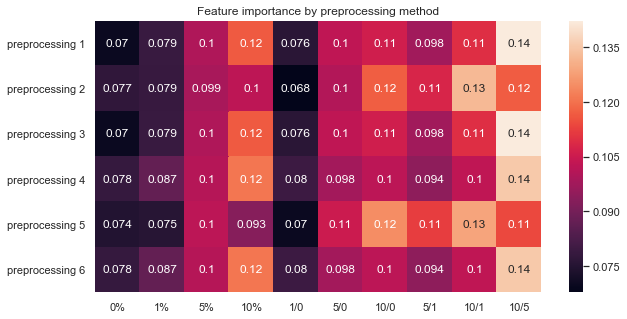

In [23]:
#importances of each data set at n_estimators=100
importance_arr = np.array([all_features[0][3], all_features[1][3], all_features[2][3], 
                           all_features[3][3], all_features[4][3], all_features[5][3]])

#making a nice heat plot
sns.set(rc={'figure.figsize':(10, 5)})
ax = sns.heatmap(importance_arr, annot=True, 
            xticklabels=['0%', '1%', '5%', '10%', '1/0', '5/0', '10/0', '5/1', '10/1', '10/5'],
            yticklabels=['preprocessing 1', 'preprocessing 2', 'preprocessing 3',
                         'preprocessing 4', 'preprocessing 5', 'preprocessing 6']) 
ax.set_ylim(6,0)
plt.title('Feature importance by preprocessing method')

plt.show()


It looks like z-score the ratios by protein makes 10/0, 5/1, and 10/1 a little more predictive while z-scoring signal by protein makes the 10% data more predictive. As stated above, we'll use the 5th preprocessing scheme.

In [24]:
#getting the training / test data for dataset 3
X_train = X_trains[4]
X_test = X_tests[4]
y_train = y_trains[4]
y_test = y_tests[4]

Report function in the scikit-learn was used to help with extracting grid search and random search results.

In [25]:
# Utility function to report best scores
def report(results, n_top=3):
    all_params = []
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            all_params.append(results['params'][candidate])
    return all_params

Random search for parameters that yield the best model through 5-fold crossvalidation was performed. 

In [26]:
# build a classifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)

# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 10),
              "min_samples_split": sp_randint(2, 10),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 25
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, random_state = 0)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
all_params = report(random_search.cv_results_)

RandomizedSearchCV took 19.80 seconds for 25 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.408 (std: 0.067)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 4, 'min_samples_split': 7}

Model with rank: 2
Mean validation score: 0.402 (std: 0.055)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 6, 'min_samples_split': 8}

Model with rank: 3
Mean validation score: 0.398 (std: 0.041)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'min_samples_split': 3}



Looks like we have a winner. Let's get those parameters and get to building a model.

In [53]:
#select parameters
params = all_params[0]

We can plot a confusion matrix to see how the model did with 5-fold cross validation on the data set and then see how it did on the 5 metabolicly linked groups of amino acids.

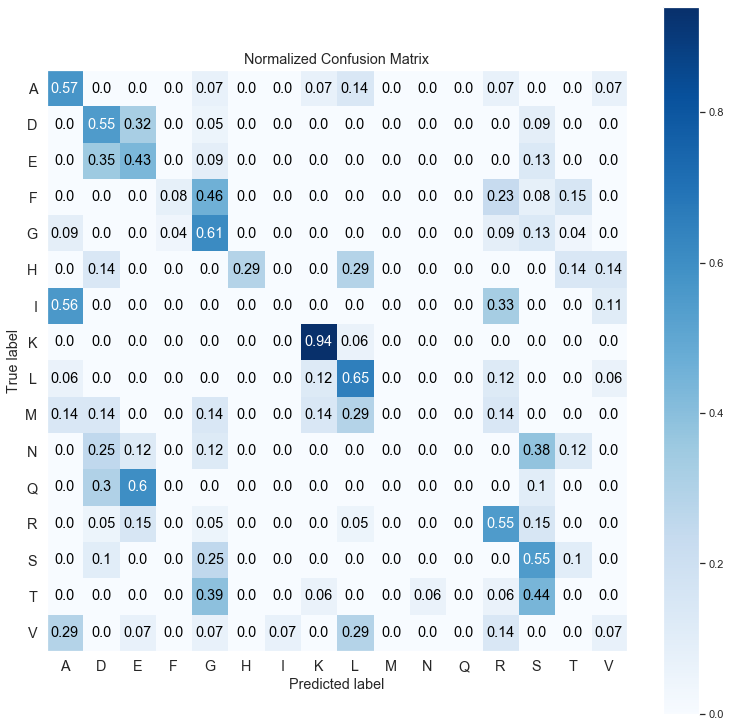

In [54]:
clf = RandomForestClassifier(n_estimators=100, **params, random_state=0)
y_preds = cross_val_predict(clf, X_train, y_train, cv=5)

ax = skplt.metrics.plot_confusion_matrix(y_train, y_preds, normalize=True,
                                    figsize=(13,13), title_fontsize='large', text_fontsize='large')
ax.set_ylim(15.5, -0.5)
plt.show()

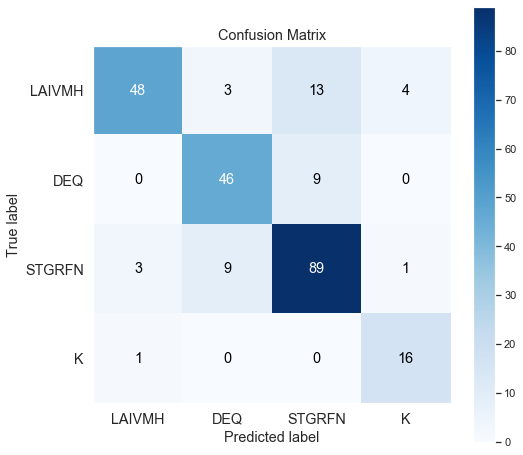

In [55]:
y_condensed = np.array([condensed_dict[i] for i in y_train])
preds_condensed = np.array([condensed_dict[i] for i in y_preds])

ax = skplt.metrics.plot_confusion_matrix(y_condensed, preds_condensed, normalize=False, labels = ['LAIVMH', 'DEQ', 'STGRFN', 'K'], 
                                    figsize=(8,8), title_fontsize='large', text_fontsize='large')
ax.set_ylim(3.5, -0.5)
plt.show()

In [56]:
val_confusion_cond = confusion_matrix(y_condensed, preds_condensed)
accuracy_cond = np.trace(val_confusion_cond) / np.sum(val_confusion_cond)
print('Accuracy: ' + str(accuracy_cond))

f1 = f1_score(y_condensed, preds_condensed, average='micro')
print('micro f1: ' + str(f1))



Accuracy: 0.8223140495867769
micro f1: 0.8223140495867769


This accuracy seems workable. Now, we fit the model to all of the training data and see how it performs on test data.

In [60]:
X_train.shape

(242, 10)

In [59]:
y_test

259    S
220    M
74     L
187    I
185    H
110    T
190    I
188    I
16     D
9      D
141    D
260    S
109    T
204    K
152    E
245    R
213    L
166    F
90     R
65     K
186    I
140    D
56     I
60     K
200    K
77     L
231    Q
Name: AA, dtype: category
Categories (19, object): [A, C, D, E, ..., T, V, W, Y]

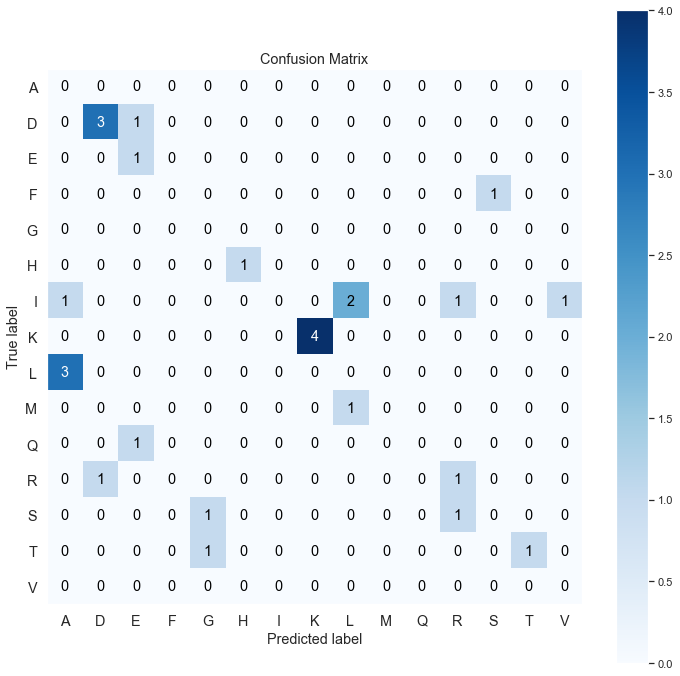

In [57]:
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
ax = skplt.metrics.plot_confusion_matrix(y_test, preds, normalize=False,
                                    figsize=(12,12), title_fontsize='large', text_fontsize='large')
ax.set_ylim(14.5, -0.5)
plt.show()

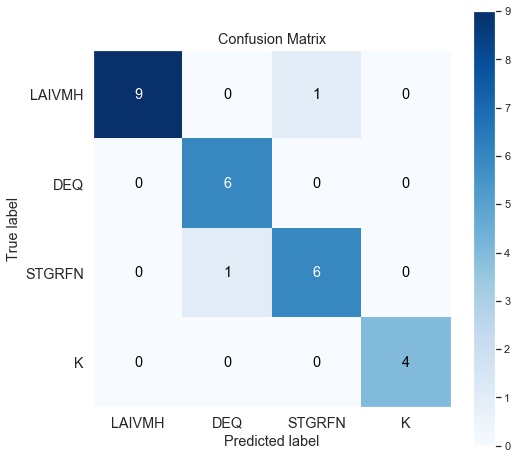

In [58]:
y_condensed = np.array([condensed_dict[i] for i in y_test])
preds_condensed = np.array([condensed_dict[i] for i in preds])

ax = skplt.metrics.plot_confusion_matrix(y_condensed, preds_condensed, normalize=False, labels = ['LAIVMH', 'DEQ', 'STGRFN', 'K'], 
                                    figsize=(8,8), title_fontsize='large', text_fontsize='large')
ax.set_ylim(3.5,-0.5)
plt.show()

In [36]:
val_confusion_cond = confusion_matrix(y_condensed, preds_condensed)
accuracy_cond = np.trace(val_confusion_cond) / np.sum(val_confusion_cond)
print('Accuracy: ' + str(accuracy_cond))

f1_cond = f1_score(y_condensed, preds_condensed, average='micro')
print('micro f1: ' + str(f1_cond))

Accuracy: 0.9259259259259259
micro f1: 0.9259259259259259


Performance looks great!

## Looking at individual prediction probabilities
If curious, we can look at the proportion of decision tress that vote for a particular amino acid:

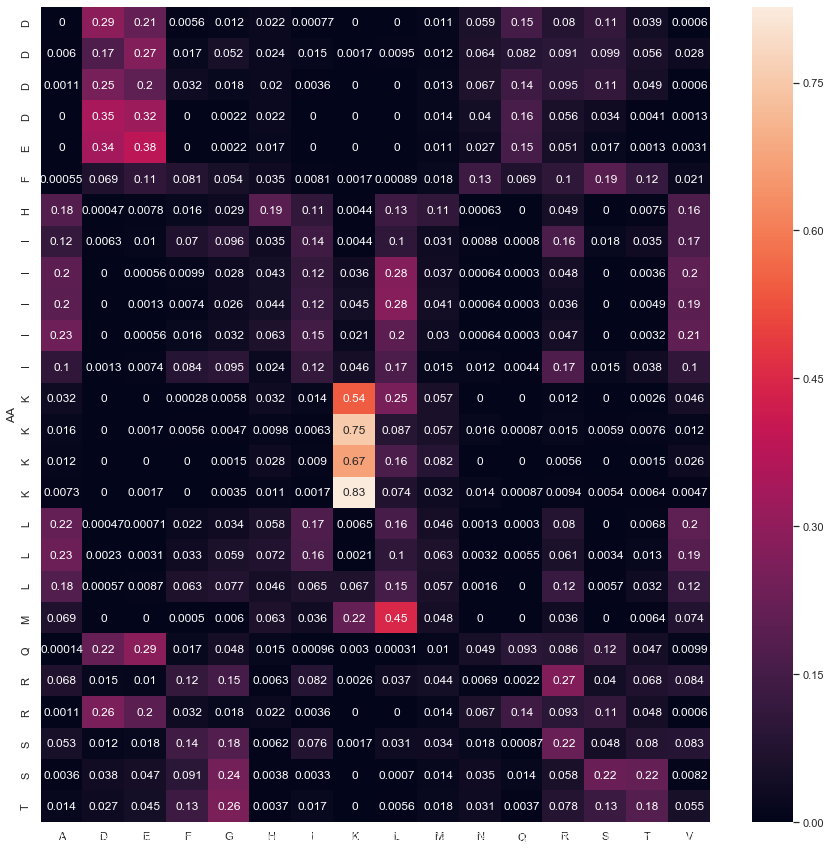

In [48]:
sns.set(rc={'figure.figsize':(15,15)})
preds_proba = clf.predict_proba(X_test)
labels.sort()
preds_proba_df = pd.DataFrame(preds_proba, columns=labels, index=y_test)
preds_probab_df = preds_proba_df.sort_index(inplace=True)
ax = sns.heatmap(preds_proba_df, annot=True)
ax.set_ylim(26, 0)
plt.show()

It appears that predictions for K and for E or D are most robust.

## Exporting fit model

We can export this model as a pickle file for easier use by users.

In [31]:
import pickle
filename = 'model/IGPS_PTP1B_model.sav'
pickle.dump(clf, open(filename, 'wb'))